<a href="https://colab.research.google.com/github/elliemmiller/datascience/blob/main/Module3FirstPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Module 3 First Pass: Supervised Classification**

Produced by: Ellie Miller

This assignment aims to compare at least 3 different supervised methods (scoring, time, lines of code).


Like the Unsupervised Machine Learning module, I am changing the dataset I am using for the Supervised Classification module due to challenges with accessing and uploading Copernicus Sentinel-2 Optical Imagery.

I am instead using a "Water Quality and Potability" dataset from Kaggle (meaning it is publically available).

**More info about the dataset here:**
This dataset contains water quality measurements and assessments related to potability, which is the suitability of water for human consumption. The dataset's primary objective is to provide insights into water quality parameters and assist in determining whether the water is potable or not. Each row in the dataset represents a water sample with specific attributes, and the "Potability" column indicates whether the water is suitable for consumption.



**Set Up**

In [ ]:
# Import necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile

# Supervised machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Access the API to load the dataset and save it as a ZIP
!kaggle datasets download -d uom190346a/water-quality-and-potability

with zipfile.ZipFile("water-quality-and-potability.zip", 'r') as zip_ref:
    zip_ref.extractall("waterqualityandpotability")

Dataset URL: https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability
License(s): apache-2.0
water-quality-and-potability.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Load the database file
waterqualityandpotability = pd.read_csv('/content/waterqualityandpotability/water_potability.csv')

**Initial Exploratory Data Analysis**

In [ ]:
# Figure out how big the dataset is
waterqualityandpotability.shape

(3276, 10)

In [ ]:
# Remove any row with no data
waterqualityandpotabilitye = waterqualityandpotability.dropna()
waterqualityandpotability.shape

(3276, 10)

There are no rows in the dataset that have no data in them, so the size of the dataset stays the same!

In [ ]:
# Figure out what is included in the dataset
waterqualityandpotability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


I believe all columns are relevant for the supervised classification algorithm and don’t see a need to remove any, but I’d love to hear your thoughts!

In [ ]:
waterqualityandpotability.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


**Expanded EDA**

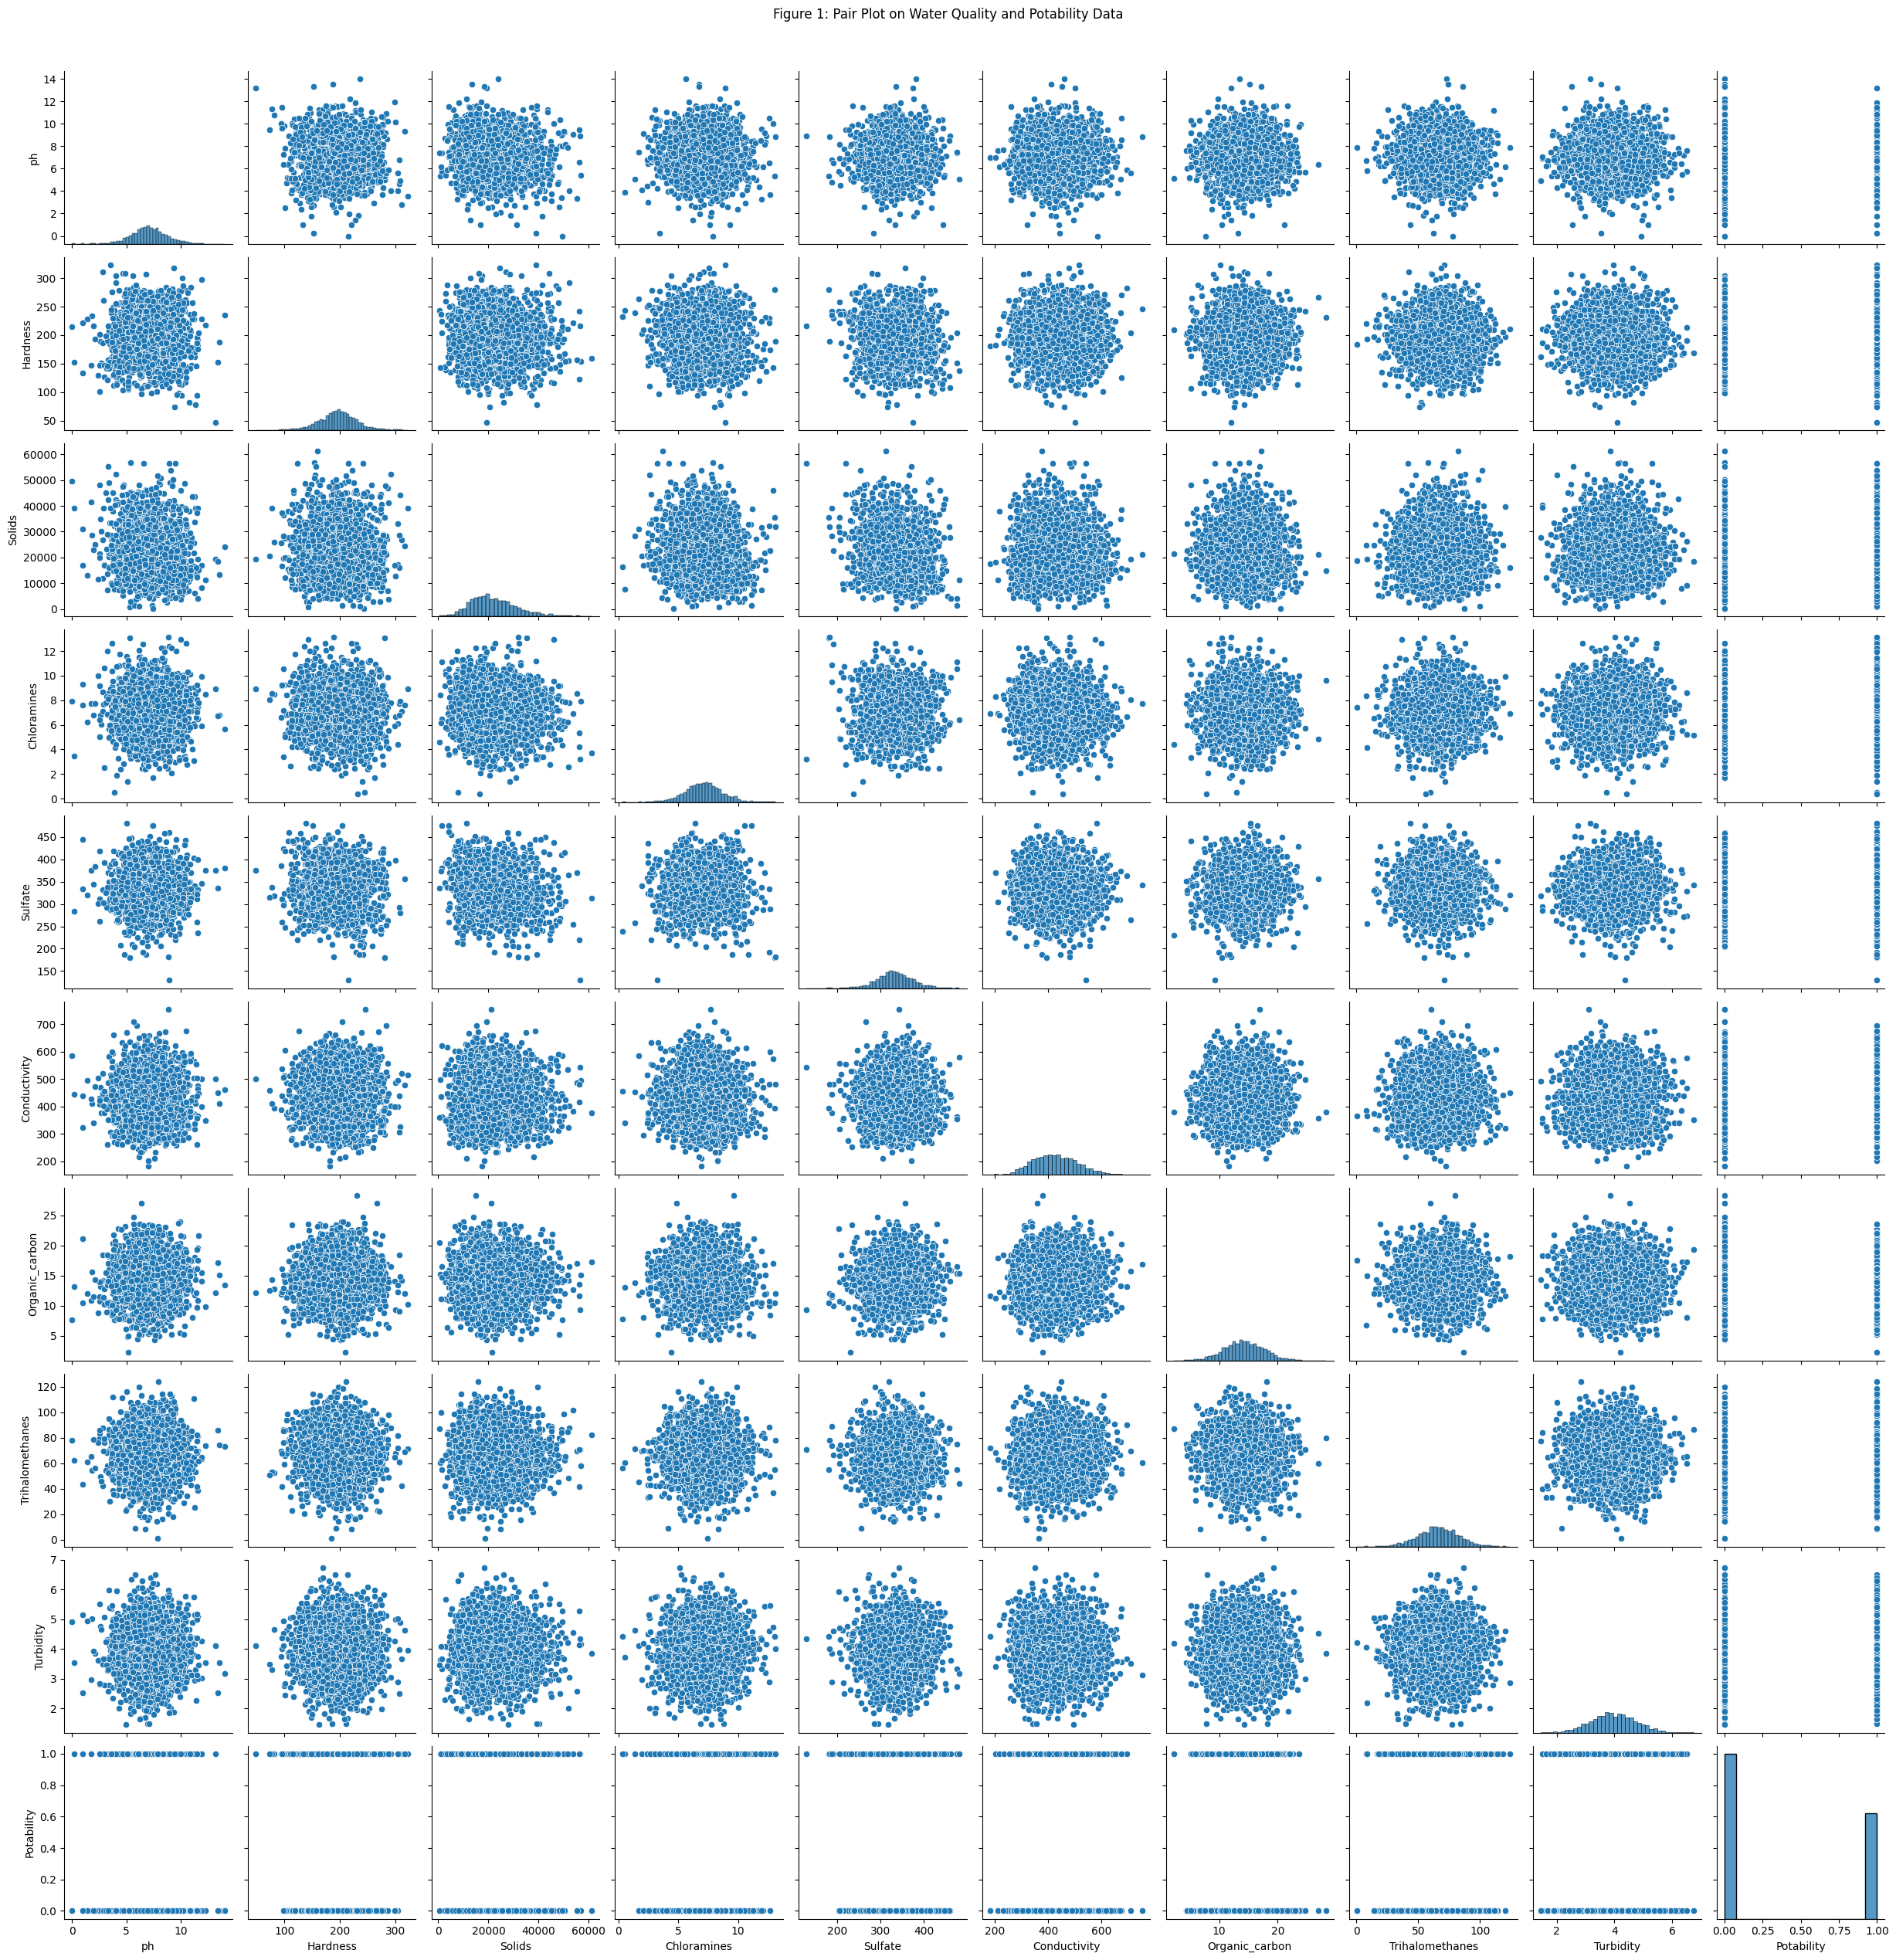

In [ ]:
# Run pairplot on data
sns.pairplot(waterqualityandpotability)
plt.suptitle("Figure 1: Pair Plot on Water Quality and Potability Data", y=1.02)
plt.show()

The pair plot provides a comprehensive visualization of relationships among numerical features in the water quality dataset. Each scatter plot represents a bivariate relationship, while the diagonal histograms depict the distribution of individual variables. Most scatter plots exhibit a cloud-like distribution with no strong linear trends, suggesting weak correlations between most variables. However, certain variables, such as Hardness, Conductivity, and Solids, display some degree of clustering, hinting at possible relationships. The Potability variable, being binary, is aligned along discrete values in its pairwise plots, reinforcing its categorical nature. The presence of widely spread points suggests significant data variability, and potential non-linear dependencies may require further statistical analysis.


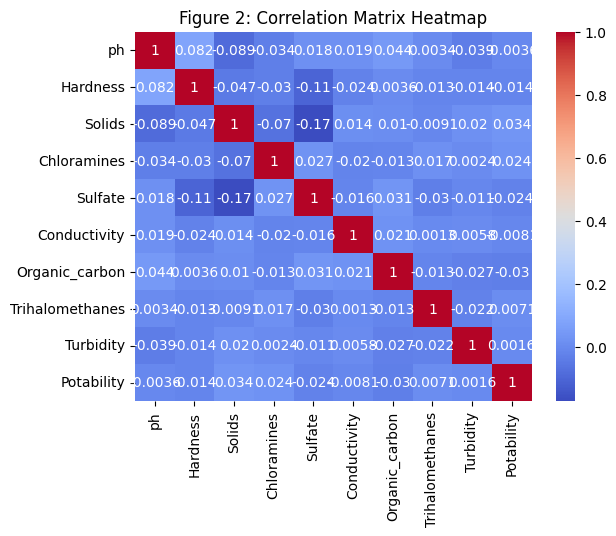

In [ ]:
# Calculate the correlation matrix
corr_matrix = waterqualityandpotability.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Figure 2: Correlation Matrix Heatmap')
plt.show()


The correlation matrix heatmap reveals weak relationships among water quality parameters, with most correlations near zero. Potability shows minimal correlation with other variables, indicating that no single factor strongly determines water safety. Weak negative correlations exist, such as between Hardness and Sulfate (-0.11) and Solids and Sulfate (-0.17), but they are not significant. The low interdependence suggests that predicting potability requires a multivariate approach rather than relying on individual parameters.

In [ ]:
# Select only numeric columns
numeric_columns = waterqualityandpotability.select_dtypes(include=[np.number]).columns
numeric_data = waterqualityandpotability.select_dtypes(include=[np.number])

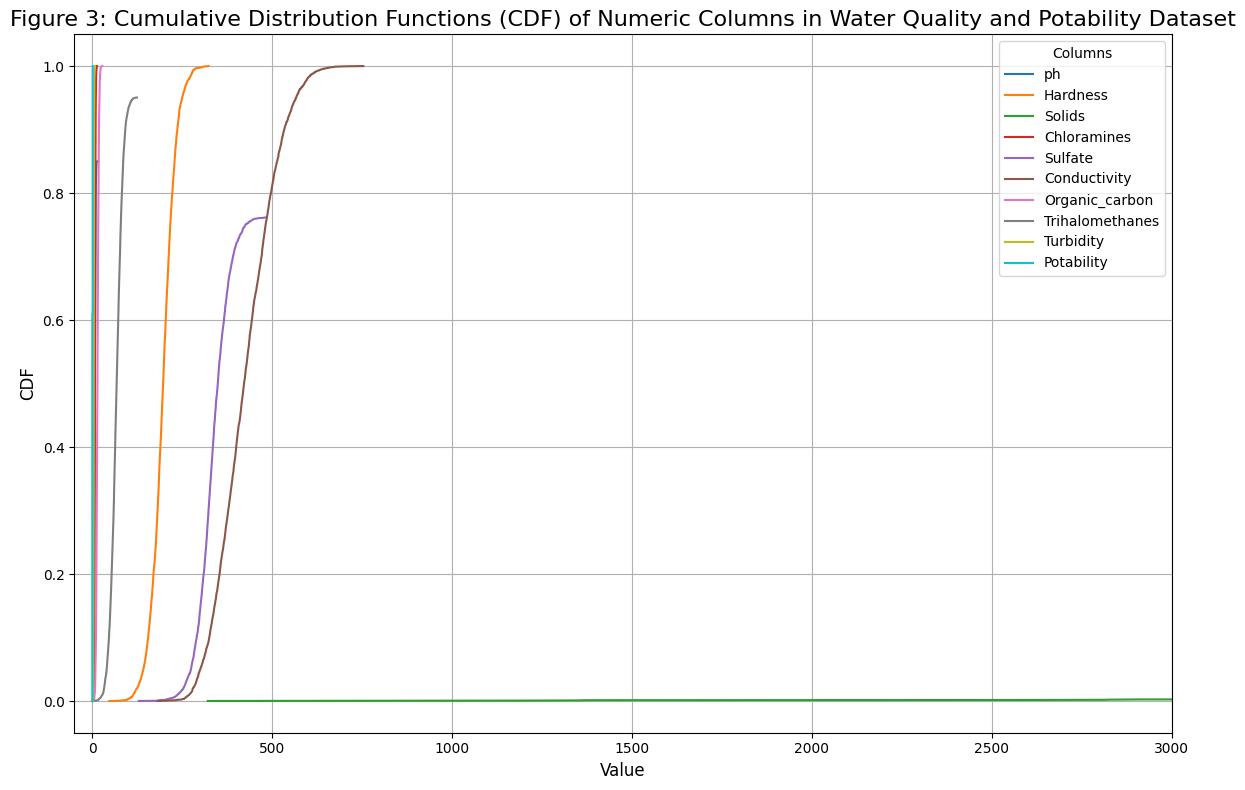

In [ ]:
# Create a single CDF plot for all numeric columns
plt.figure(figsize=(12, 8))

for column_name in numeric_columns:
    # Sort the data
    wqap = waterqualityandpotability[column_name].sort_values()

    # Calculate the CDF
    cdf = np.arange(1, len(wqap) + 1) / len(wqap)

    # Plot the CDF
    plt.plot(wqap, cdf, label=column_name)

# Plot characteristics
plt.title('Figure 3: Cumulative Distribution Functions (CDF) of Numeric Columns in Water Quality and Potability Dataset', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.xlim(-50, 3000)
plt.ylabel('CDF', fontsize=12)
plt.legend(title='Columns', fontsize=10, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()



The CDF plot reveals that most water quality parameters are highly skewed, with values concentrated within narrow ranges. Variables like Hardness and Sulfate exhibit broader distributions, while pH, Potability, and Turbidity have steep CDFs, indicating clustered values. Potability, likely binary, is concentrated at lower values. The spacing and trends among CDFs highlight distribution differences, which are crucial for data preprocessing and modeling.

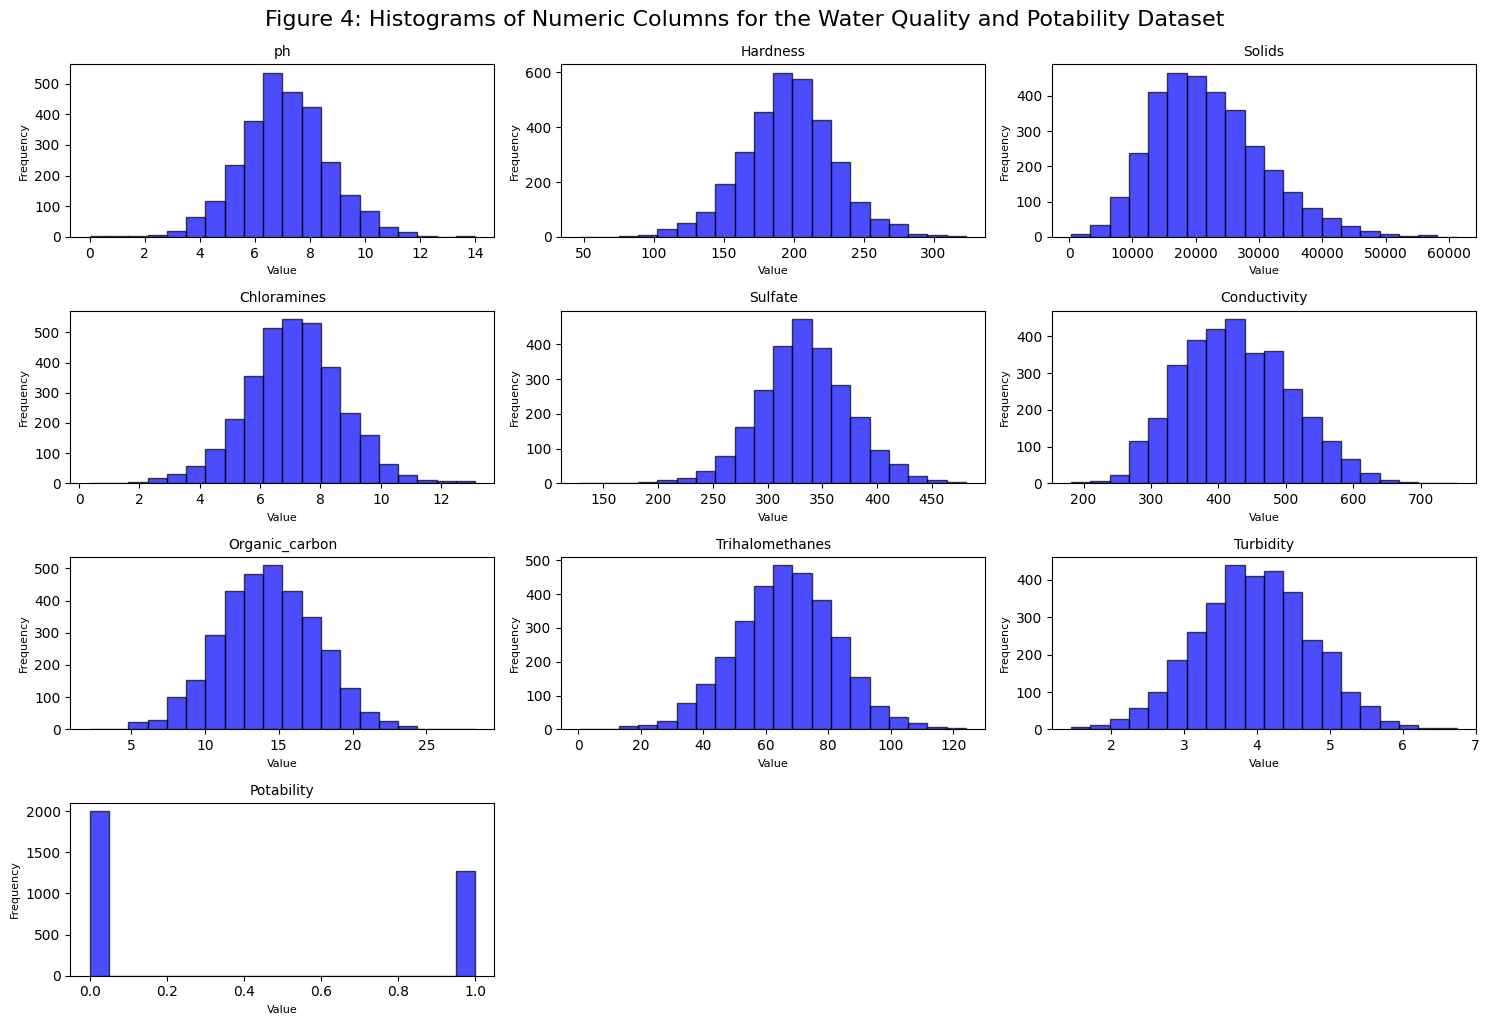

In [ ]:
# Create histograms for each numeric column
numeric_columns = numeric_data.columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot((len(numeric_columns) + 2) // 3, 3, i)
    plt.hist(numeric_data[column], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(column, fontsize=10)
    plt.xlabel('Value', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.tight_layout()

plt.suptitle("Figure 4: Histograms of Numeric Columns for the Water Quality and Potability Dataset", fontsize=16, y=1.02)
plt.show()


The histograms illustrate the distribution of key water quality parameters, showing that most variables exhibit approximately normal distributions with varying degrees of skewness. pH, Chloramines, Organic Carbon, and Turbidity are symmetrically distributed, while Solids, Sulfate, and Hardness show slight right skewness, indicating a tail of higher values. The distributions of Conductivity and Trihalomethanes also suggest some skewness, which may require transformations for further statistical analysis.

**Prep Data for Supervised Model Runs**

In [ ]:
# Handle missing values
waterqualityandpotability.dropna(inplace=True)

# Split features and target
X = waterqualityandpotability.drop(columns=['Potability'])
y = waterqualityandpotability['Potability']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

I decided to split the data just based on potability because it the target variable, but there could also be benefit to further feature engineering or grouping. Would love your thoughts on this!

**Logistic Regression**

In [ ]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       240
           1       0.50      0.01      0.01       163

    accuracy                           0.60       403
   macro avg       0.55      0.50      0.38       403
weighted avg       0.56      0.60      0.45       403

Confusion Matrix:
[[239   1]
 [162   1]]


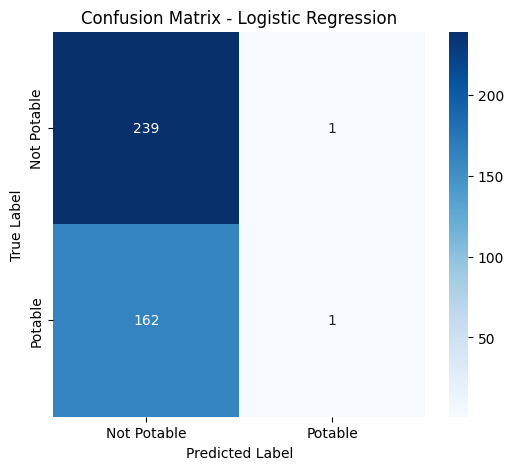

In [21]:
# Define confusion matrix values (based on the provided output)
cm = np.array([[239, 1],
               [162, 1]])

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The Logistic Regression model demonstrates significant class imbalance issues when predicting water potability. While it achieves an overall accuracy of 60%, the performance breakdown reveals that the model is highly biased toward classifying water as not potable (Class 0). This is evident in the confusion matrix, where 239 out of 240 non-potable samples were correctly classified, but only 1 out of 163 potable samples was identified correctly. The model's recall for potable water (Class 1) is extremely low (0.01), meaning it fails to recognize almost all potable water instances. This imbalance skews the precision, recall, and F1-score, making the model unreliable for identifying safe drinking water. The likely cause of this poor performance is the unequal distribution of classes in the dataset, requiring techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or class weight adjustments to improve classification. Additionally, the model may benefit from hyperparameter tuning, feature engineering, and alternative algorithms such as Random Forest or XGBoost, which tend to handle class imbalances better.

**Support Vector Machine**

In [ ]:
# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("\nSupport Vector Machine Performance:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Support Vector Machine Performance:
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       240
           1       0.78      0.33      0.47       163

    accuracy                           0.69       403
   macro avg       0.73      0.63      0.62       403
weighted avg       0.72      0.69      0.66       403

Confusion Matrix:
[[225  15]
 [109  54]]


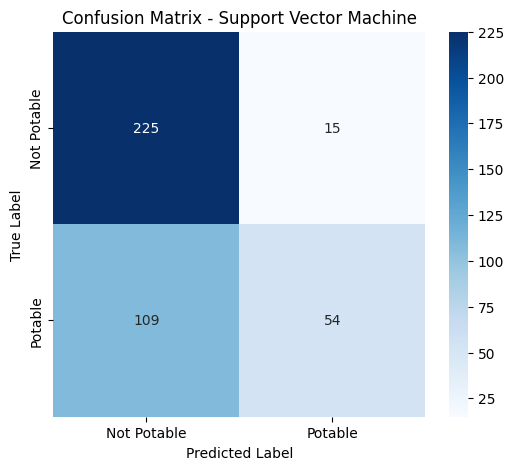

In [22]:
# Define confusion matrix values for SVM
cm_svm = np.array([[225, 15],
                   [109, 54]])

# Plot confusion matrix heatmap for SVM
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()


The Support Vector Machine (SVM) model outperforms Logistic Regression, achieving an accuracy of 69% and significantly improving the recall for potable water (33% compared to 1%). However, the model still struggles with class imbalance, favoring the Not Potable (Class 0) category, where it correctly identifies 94% of non-potable samples but misclassifies 109 out of 163 potable samples as non-potable. This results in a low F1-score of 0.47 for potable water, meaning the model is still unreliable for detecting safe drinking water. The bias toward non-potable water suggests that improvements are needed, such as balancing the dataset using SMOTE, tuning hyperparameters (e.g., kernel choice, regularization), and exploring feature engineering techniques. Despite these shortcomings, the SVM model demonstrates better classification performance than Logistic Regression, indicating that with further optimizations, it could be a strong candidate for water potability classification.

**Gradient Boosting**

In [ ]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
print("\nGradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.64      0.89      0.75       240
           1       0.63      0.28      0.38       163

    accuracy                           0.64       403
   macro avg       0.64      0.58      0.57       403
weighted avg       0.64      0.64      0.60       403

Confusion Matrix:
[[214  26]
 [118  45]]


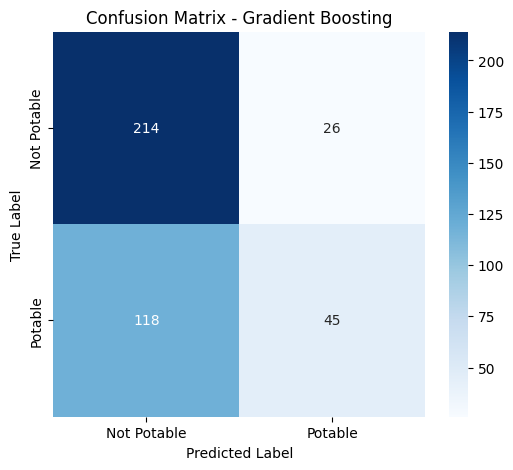

In [23]:
# Define confusion matrix values for Gradient Boosting
cm_gb = np.array([[214, 26],
                  [118, 45]])

# Plot confusion matrix heatmap for Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()



The Gradient Boosting model demonstrates moderate performance, achieving an accuracy of 64%, which is higher than Logistic Regression (60%) but lower than SVM (69%). While it shows a better balance in precision between the two classes (0.64 for non-potable and 0.63 for potable water), its recall for potable water is only 28%, meaning it fails to correctly classify the majority of potable water samples. The confusion matrix confirms this issue, with 118 misclassified potable samples, making it unreliable for identifying safe drinking water. Compared to SVM, which has higher recall for potable water (33%), Gradient Boosting struggles more with false negatives, making it less suitable for real-world applications where correctly identifying potable water is crucial. The model’s high recall for non-potable water (89%) suggests it prioritizes avoiding false positives, which may be useful in certain contexts, but it still requires dataset balancing (SMOTE), hyperparameter tuning, and possibly feature selection to improve its ability to recognize potable water.

**Comparison of the Three Supervised Models**

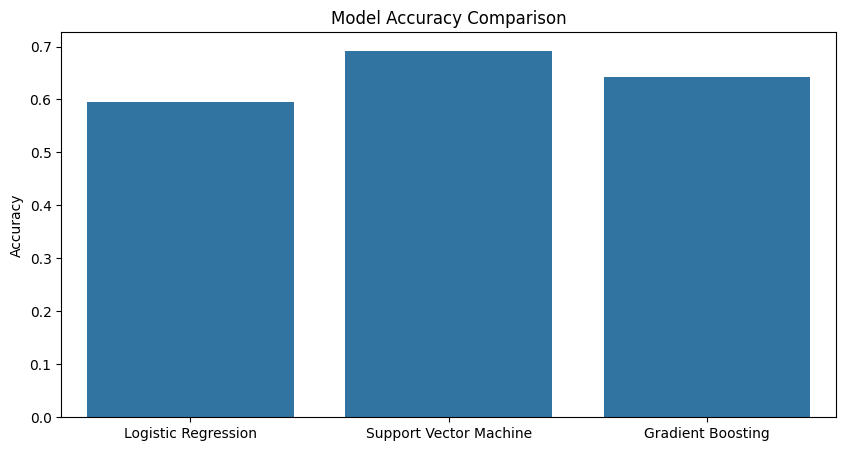

In [24]:
# Plot comparison
results = {
    'Logistic Regression': acc_log_reg,
    'Support Vector Machine': acc_svm,
    'Gradient Boosting': acc_gb
}

plt.figure(figsize=(10,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


The model accuracy comparison highlights that the Support Vector Machine (SVM) model performs the best, achieving the highest accuracy among the three models. Logistic Regression has the lowest accuracy, indicating that its linear nature struggles to capture the complexities of the dataset. Gradient Boosting, while expected to perform well due to its ensemble learning approach, falls slightly behind SVM, suggesting that it may require further hyperparameter tuning to optimize performance. The fact that all three models achieve accuracies below 70% indicates that additional improvements—such as feature selection, class balancing (SMOTE), or testing alternative models like Random Forest or XGBoost—may be necessary to improve classification performance, particularly in correctly identifying potable water samples.









***Which method did you like the most?***

The Support Vector Machine (SVM) model performed the best overall, achieving the highest accuracy (69%) and the best recall for potable water (33%). It showed the strongest classification ability while still leaving room for improvement in detecting potable water.

***Which method did you like the least?***

Logistic Regression was the least effective, with an accuracy of only 60% and a recall of 1% for potable water, making it almost entirely ineffective at identifying safe drinking water.

***How did you score these supervised models?***

The models were evaluated using accuracy, precision, recall, and F1-score. Additionally, confusion matrices were analyzed to understand misclassifications, particularly focusing on false negatives (misclassified potable water).

***Did the output align with your geologic understanding?***

Not entirely. Given the importance of identifying safe drinking water, the high false negative rates for potable water indicate that the models are biased toward classifying water as non-potable. This suggests that additional feature engineering or dataset improvements are necessary.

***Did you hyperparameter tune? Why or why not?***

No, hyperparameter tuning was not performed in this initial comparison, but it would likely improve model performance. SVM could benefit from kernel tuning, and Gradient Boosting could be optimized by adjusting the learning rate and max depth.

**How did you split your data? And why does that make sense for this dataset?**

The data was split into 80% training and 20% testing, ensuring a fair evaluation of model performance. Since this is a classification problem with class imbalance, stratified sampling should also be used to maintain the same proportion of potable and non-potable samples in both sets.

***What did you want to learn more about?***

I want to explore feature engineering and alternative models, such as XGBoost and Random Forest, to see if they handle class imbalance more effectively. Additionally, testing SMOTE (Synthetic Minority Over-sampling Technique) would help improve recall for potable water.

***Did you pre-process your data?***

Yes, the data was preprocessed by handling missing values and standardizing features using StandardScaler to ensure consistency across models.

***Do all models require pre-processing?***

Not necessarily. Tree-based models (like Gradient Boosting and Random Forest) do not require standardization but still benefit from handling missing values. However, SVM and Logistic Regression perform significantly better when features are standardized, making pre-processing a crucial step.